# Feature Reduction Comparison
In this notebook, I explore different means of feature reduction on greyscale images. In specific, I will compare 
 - Principal Component Analysis, 
 - Flat Auto-Encoder, and 
 - Convolutional Auto-encoder. 
 
The results will be compared both visually and in numbers terms of numbers. The scikit dataset of greyscale faces serves as example.

***This is a work in progress***

In [0]:
import numpy as np
from numpy.linalg import eig, eigvals
from sklearn.datasets import fetch_lfw_people
from src.plot_functions import plot_faces, plot_faces_compare, plot_variance_retention

np.random.seed(42)

## Loading and Displaying Dataset 

In [3]:
# Read and shuffle data
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.4)

n_samples, h, w = faces.images.shape
n_features = h * w
X = faces.data
np.random.shuffle(X)

print("{} samples in dataset".format(n_samples))
print("{} features per sample".format(n_features))
print("{}x{}px image dimension".format(h, w))

3023 samples in dataset
1850 features per sample
50x37px image dimension


In [0]:
# Shuffling and mean normalization
mu_norm = np.mean(X, axis=1)
X_norm = (X.T - mu_norm).T

In [0]:
# Train and test split
test_ratio = 0.2

n_samples_train = int((1-test_ratio) * X.shape[0])
X_train = X_norm[:n_samples_train]
X_test = X_norm[n_samples_train:]
mu_train = mu_norm[:n_samples_train]
mu_test = mu_norm[n_samples_train:]

print("{} samples in train set".format(X_train.shape[0]))
print("{} samples in test set".format(X_test.shape[0]))

2418 samples in train set
605 samples in test set


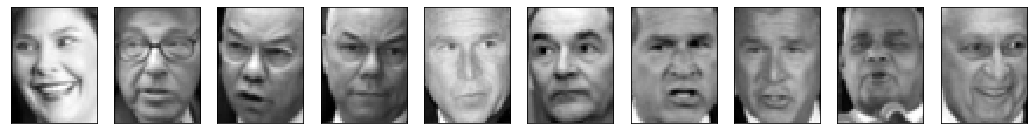

In [0]:
plot_faces(X_train, h, w, 0.8, n_row=1, n_col=10)

## Reduction through PCA

In [0]:
# Compute covariance matrix (equivalent to np.cov(...))
Sigma = 1/n_features * X_train.T.dot(X_train)

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = eig(Sigma)

In [0]:
def get_U_reduce(var_retain, eig):
    """Computes the reduction matrix for PCA"""
    
    eigvals_cumulative = np.array([sum(eig[0:i]) / sum(eig) for i in range(0, len(eig+1))])
    U_n = np.where(eigvals_cumulative >= var_retain)[0][0] + 1
    U_red = eigvecs[:, 0:U_n]
    retention = eigvals_cumulative[U_n-1]
    
    return U_red, retention, eigvals_cumulative

In [0]:
var_retain = 0.99
U_reduce, retention, retention_array = get_U_reduce(var_retain, eigvals)

print("{} features required to retain {:.3f}% of data".format(U_reduce.shape[1], retention*100))
print("Data compressed by {:.0f}%".format((1 - U_reduce.shape[1] / X.shape[1]) * 100))

383 features required to retain 99.002% of data
Data compressed by 79%


The Variance Retention curve shows which level of variance can be retained over a certain number of eigenvectors or features in the reduced dataset. In the example above, we see that 386 features suffice to retain 99% of the variance of the original dataset. This correp

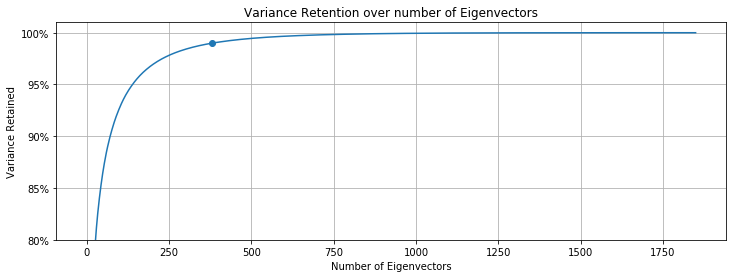

In [0]:
plot_variance_retention(retention_array, var_retain)

In [0]:
def image_similarity(X1, X2):
    """Computes the percentage similarity of two images"""
    
    return 1 - (abs(X1 - X2) / 255.0).mean()

In [0]:
def reduce_and_recover(U_red, X):
    """Reduces features in X according to reduction matrix U_red"""
    
    X_red = X.dot(U_red)
    X_rec = X_red.dot(U_red.T)
    
    return X_rec

In [0]:
# Recover train dataset
X_train_recovered = reduce_and_recover(U_reduce, X_train)

# Reverse the mean normalization
X_train_recovered = (X_train_recovered.T + mu_train).T
X_train_ = (X_train.T + mu_train).T

# Compute the image similarity in %
sim_train = image_similarity(X_train_, X_train_recovered)

print("The train images are {:.3f}% similar".format(sim_train * 100))

The train images are 98.781% similar


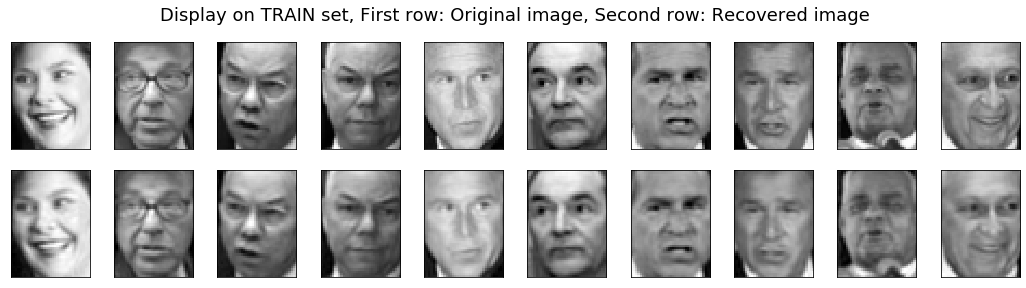

In [0]:
plot_faces_compare(X_train, X_train_recovered, h, w, 0.8, 10, 
                   suptitle="Display on TRAIN set, First row: Original image, Second row: Recovered image")

In [0]:
X_test_recovered = reduce_and_recover(U_reduce, X_test)

# Reverse the mean normalisation
X_test_recovered = (X_test_recovered.T + mu_test).T
X_test_ = (X_test.T + mu_test).T

# Compute the image similarity in %
sim_test = image_similarity(X_test_, X_test_recovered)

print("The test images are {:.3f}% similar".format(sim_test * 100))

The test images are 98.492% similar


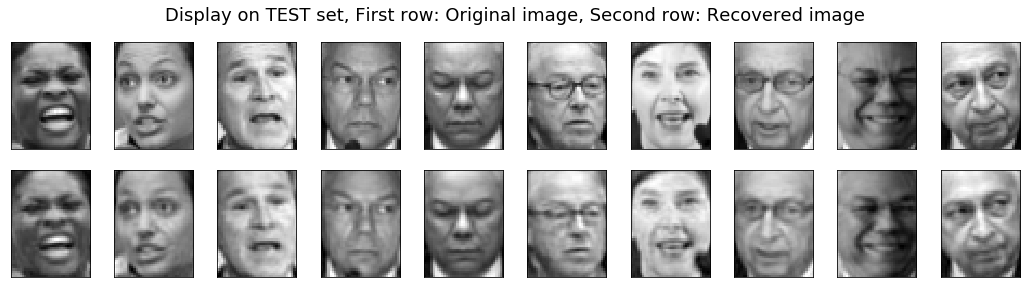

In [0]:
plot_faces_compare(X_test, X_test_recovered, h, w, 0.8, 10,
                  suptitle="Display on TEST set, First row: Original image, Second row: Recovered image")

The block below shows different Variance Retention levels along with some recovered images and an image similarity evaluation. The plot below clearly shows that, with decreasing Variance Retention level, the number of specified features disappear in the image representation.

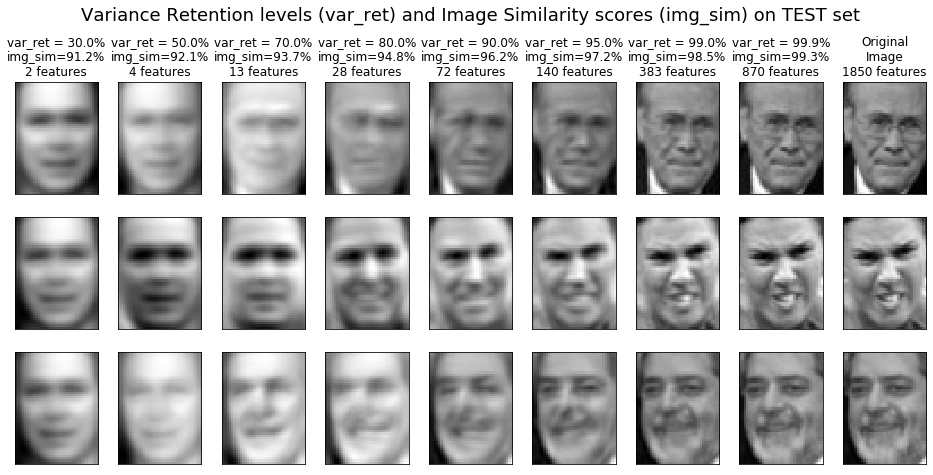

In [0]:
n_images, scaling = 3, 0.9
variance_levels = [0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]
test_or_train = "TEST" # "TRAIN" or "TEST

X_plot, X_plot_, mu_plot = None, None, None
if test_or_train == "TEST":
    X_plot, X_plot_, mu_plot = X_test, X_test_, mu_test
else:
    X_plot, X_plot_, mu_plot = X_train, X_train_, mu_train

series_images, series_sim, series_features = [], [], []
image_id = np.random.randint(0, X_plot.shape[0], size=(1,n_images))
n_levels = len(variance_levels)

# Perform PCA and recovery for all variance levels
for i_var in variance_levels:
    tmp_U_reduce = get_U_reduce(i_var, eigvals)[0]
    tmp_X_recovered = (reduce_and_recover(tmp_U_reduce, X_plot).T + mu_plot).T
    
    series_features.append(tmp_U_reduce.shape[1])
    series_sim.append(image_similarity(X_plot_, tmp_X_recovered))    
    series_images.append(tmp_X_recovered[image_id])

series_images.append(X_plot[image_id])

# Print example images for different variance levels
plt.figure(figsize=(1.8 * n_levels * scaling, 2.4 * n_images * scaling))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.82, hspace=.20)
plt.suptitle("Variance Retention levels (var_ret) and Image Similarity scores (img_sim) on {} set".format(
        test_or_train), fontsize = 18)

for i in range(n_levels + 1):
    for j in range(n_images):
        plt.subplot(n_images, n_levels + 1, j * (n_levels+1) + i + 1 )
        plt.imshow(series_images[i][0][j].reshape((h, w)), cmap=plt.cm.gray)
        if j == 0:
            if i == n_levels:
                plt.title("Original\nImage\n{} features".format(X_test_.shape[1]))
            else:
                plt.title("var_ret = {:.1f}%\nimg_sim={:.1f}%\n{} features".format(
                        variance_levels[i] * 100, series_sim[i] * 100, series_features[i]))
        plt.xticks(())
        plt.yticks(())

plt.show()

## Reduction through Flat Auto-Encoder

In [4]:
from time import time
import os
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers.core import Dense, Activation
from keras.regularizers import L1L2
from keras.optimizers import adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [0]:
# Standardisation of the dataset
mu_stand = X.mean(axis=0)
sigma_stand = X.std(axis=0)
X_stand = ((X - mu_stand) / sigma_stand)

# Reverse conversion
# X = X_stand * sigma_stand + mu_stand

In [9]:
test_ratio = 0.15
val_ratio = 0.15

n_samples_train = int((1-test_ratio-val_ratio) * X.shape[0])
n_samples_val = int(test_ratio * X.shape[0])

X_train = X[:n_samples_train]
X_val = X[n_samples_train:(n_samples_train + n_samples_val)]
X_test = X[(n_samples_train + n_samples_val):]

X_stand_train = X_stand[:n_samples_train]
X_stand_val = X_stand[n_samples_train:(n_samples_train + n_samples_val)]
X_stand_test = X_stand[n_samples_train:]

print("{} samples in train set".format(X_train.shape[0]))
print("{} samples in validation set".format(X_val.shape[0]))
print("{} samples in test set".format(X_test.shape[0]))

2116 samples in train set
453 samples in validation set
454 samples in test set


In [0]:
# Building the model
model = Sequential()

reg_lambda = 0.0
decay = 3e-6
alpha = 0.0001
reg = L1L2()

# Encoder Architecture
model.add(InputLayer(input_shape=(X_stand_train.shape[1],)))
model.add(Dense(1024, activation='relu', kernel_regularizer=reg))

# Compressed Representation, using the same feature count as PCA with 99% var retention
model.add(Dense(383, activation='relu', kernel_regularizer=reg))

# Decoder Architecture
model.add(Dense(1024, activation='relu', kernel_regularizer=reg))
model.add(Dense(X_stand_train.shape[1], activation='linear', kernel_regularizer=reg))

# Compiling the model
model.compile(loss = 'mse', optimizer=adam(lr=alpha, decay=decay))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              1895424   
_________________________________________________________________
dense_6 (Dense)              (None, 383)               392575    
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              393216    
_________________________________________________________________
dense_8 (Dense)              (None, 1850)              1896250   
Total params: 4,577,465
Trainable params: 4,577,465
Non-trainable params: 0
_________________________________________________________________


In [0]:
# If the sub-folder models does not exist, create it
if not os.path.exists('models'):
    os.makedirs('models')

mcp = ModelCheckpoint("models/weights.{val_loss:.3f}.{epoch:02d}-.hdf5", save_best_only=True)
ecp = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

start = time()

history = model.fit(X_stand_train, X_stand_train, 
                    epochs=200, batch_size=16, 
                    verbose=2, validation_data=(X_stand_val, X_stand_val),
                    callbacks=[mcp, ecp])

print("Total training time {:.0f}s".format(time() - start))

Train on 2116 samples, validate on 453 samples
Epoch 1/200
 - 8s - loss: 0.5061 - val_loss: 0.4239
Epoch 2/200
 - 8s - loss: 0.3665 - val_loss: 0.3289
Epoch 3/200
 - 8s - loss: 0.2905 - val_loss: 0.2795
Epoch 4/200
 - 9s - loss: 0.2484 - val_loss: 0.2501
Epoch 5/200
 - 9s - loss: 0.2194 - val_loss: 0.2256
Epoch 6/200
 - 9s - loss: 0.1970 - val_loss: 0.2115
Epoch 7/200
 - 8s - loss: 0.1790 - val_loss: 0.1967
Epoch 8/200
 - 9s - loss: 0.1649 - val_loss: 0.1856
Epoch 9/200
 - 9s - loss: 0.1537 - val_loss: 0.1769
Epoch 10/200
 - 9s - loss: 0.1432 - val_loss: 0.1696
Epoch 11/200
 - 8s - loss: 0.1356 - val_loss: 0.1632
Epoch 12/200
 - 9s - loss: 0.1278 - val_loss: 0.1587
Epoch 13/200
 - 9s - loss: 0.1212 - val_loss: 0.1515
Epoch 14/200
 - 8s - loss: 0.1157 - val_loss: 0.1466
Epoch 15/200
 - 8s - loss: 0.1116 - val_loss: 0.1430
Epoch 16/200
 - 8s - loss: 0.1065 - val_loss: 0.1401
Epoch 17/200
 - 8s - loss: 0.1023 - val_loss: 0.1368
Epoch 18/200
 - 8s - loss: 0.0984 - val_loss: 0.1336
Epoch 19

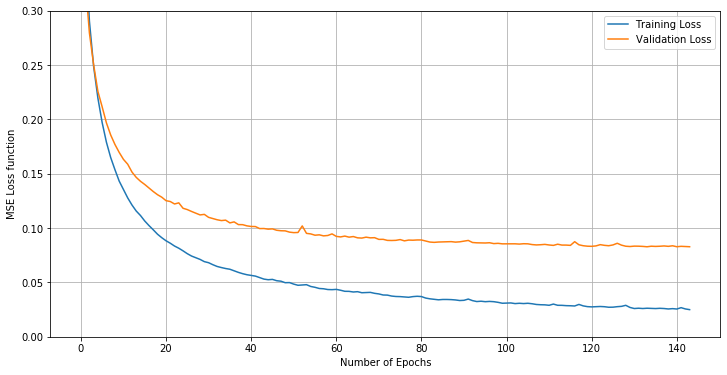

In [0]:
plt.figure(figsize=(12,6))
plt.plot(history.epoch, history.history["loss"], label="Training Loss")
plt.plot(history.epoch, history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()
plt.ylim(0, 0.3)
plt.ylabel("MSE Loss function")
plt.xlabel("Number of Epochs")
plt.show()

The train images are 98.136% similar


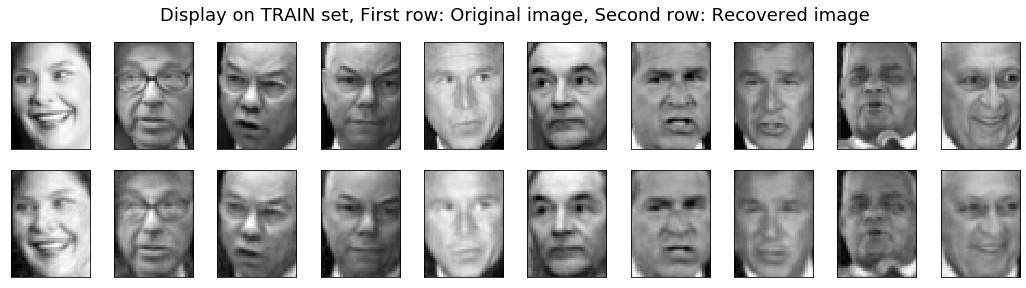

In [0]:
X_predict_train = model.predict(X_stand_train) * sigma_stand + mu_stand

fae_sim_train = image_similarity(X_predict_train, X_train)
print("The train images are {:.3f}% similar".format(fae_sim_train*100))

plot_faces_compare(X_train, X_predict_train, h, w, 0.8, 10, 
                   suptitle="Display on TRAIN set, First row: Original image, Second row: Recovered image")

The test images are 96.641% similar


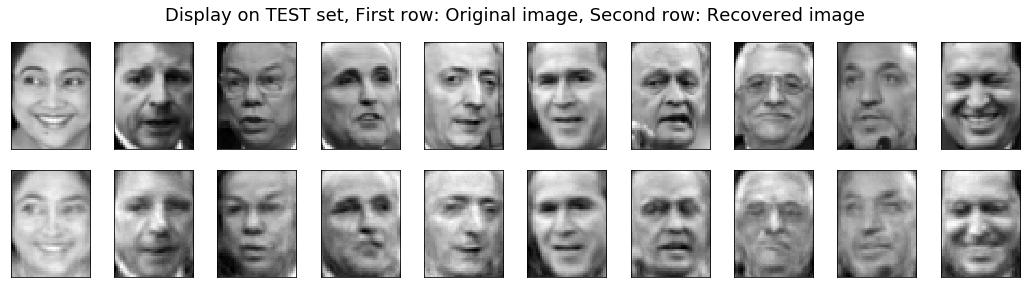

In [0]:
X_predict_val = model.predict(X_stand_val) * sigma_stand + mu_stand

fae_sim_val = image_similarity(X_predict_val, X_val)
print("The test images are {:.3f}% similar".format(fae_sim_val*100))

plot_faces_compare(X_val, X_predict_val, h, w, 0.8, 10, 
                   suptitle="Display on TEST set, First row: Original image, Second row: Recovered image")

Further hyperparameter tuning or a more elaborate study on the auto-encoder architecture will most likely lead to better results.

## Reduction through Convolutional Auto-Encoder

In [0]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import InputLayer, Dropout, Flatten, Dense, Reshape, BatchNormalization
from keras.models import Sequential

In [7]:
X_2D = X.reshape(X_stand.shape[0], h, w, 1)
X_2D = X_2D[:, 1:49, 0:36, :]
dummy1, h2, w2, dummy2 = X_2D.shape

### Normalisation will do a better job on CNNs than standardisation
X_stand_2D = X_2D / 255.0

### Alternative: Standardisation
# X_stand_2D = X_2D.reshape(X_2D.shape[0], h2*w2)
# mu_stand_2D = X_stand_2D.mean(axis=0)
# sigma_stand_2D = X_stand_2D.std(axis=0)
# X_stand_2D = ((X_stand_2D - mu_stand_2D) / sigma_stand_2D)
# X_stand_2D = X_stand_2D.reshape(X_stand_2D.shape[0], h2, w2, 1)

print("Images cropped to {}x{}".format(h2, w2))

Images cropped to 48x36


In [10]:
# Split of train, validation, and test data

test_ratio = 0.15
val_ratio = 0.15

n_samples_train = int((1-test_ratio-val_ratio) * X_2D.shape[0])
n_samples_val = int(test_ratio * X_2D.shape[0])

X_train_2D = X_2D[:n_samples_train]
X_val_2D = X_2D[n_samples_train:(n_samples_train + n_samples_val)]
X_test_2D = X_2D[(n_samples_train + n_samples_val):]

X_stand_train_2D = X_stand_2D[:n_samples_train]
X_stand_val_2D = X_stand_2D[n_samples_train:(n_samples_train + n_samples_val)]
X_stand_test_2D = X_stand_2D[n_samples_train:]

print("{} samples in train set".format(X_train_2D.shape[0]))
print("{} samples in validation set".format(X_val_2D.shape[0]))
print("{} samples in test set".format(X_test_2D.shape[0]))

2116 samples in train set
453 samples in validation set
454 samples in test set


In [46]:
# Creation of the Keras auto-encoder model
model = Sequential()

# Some hyperparameters
kernel = (3,3)
stride = (2,2)
pool = (2,2)
padding = "same"
border = "same"
alpha = 0.003

# Encoder Architecture
model.add(InputLayer(input_shape=(h2, w2, 1)))
model.add(Conv2D(filters=16, kernel_size=kernel, strides=(1,1), padding=padding, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=kernel, strides=stride, padding=padding, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=kernel, strides=stride, padding=padding, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=kernel, strides=(3,3), padding=padding, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())

# Reduced Dimension
model.add(Dense(383, activation='relu'))

# Decoder Architecture
model.add(Dense(1536, activation='relu'))
model.add(Reshape(target_shape=(4, 3, 128)))
model.add(BatchNormalization())
model.add(Conv2DTranspose(filters=64, kernel_size=kernel, strides=(3,3), padding=padding, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(filters=32, kernel_size=kernel, strides=stride, padding=padding, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(filters=16, kernel_size=kernel, strides=stride, padding=padding, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(filters=1, kernel_size=kernel, strides=(1,1), padding=padding, activation='sigmoid'))

# Compiling the model
model.compile(loss = 'mse', optimizer=adam(lr=alpha))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 48, 36, 16)        160       
_________________________________________________________________
batch_normalization_65 (Batc (None, 48, 36, 16)        64        
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 18, 32)        4640      
_________________________________________________________________
batch_normalization_66 (Batc (None, 24, 18, 32)        128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 12, 9, 64)         18496     
_________________________________________________________________
batch_normalization_67 (Batc (None, 12, 9, 64)         256       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 4, 3, 128)       

In [47]:
mcp = ModelCheckpoint("models/weights.{val_loss:.3f}.{epoch:02d}-.hdf5", save_best_only=True)
# ecp = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

start = time()

history_CNN = model.fit(X_stand_train_2D, X_stand_train_2D, 
                    epochs=200, batch_size=32, 
                    verbose=2, validation_data=(X_stand_val_2D, X_stand_val_2D))

print("Total training time {:.0f}s".format(time() - start))

Train on 2116 samples, validate on 453 samples
Epoch 1/200
 - 4s - loss: 0.0174 - val_loss: 0.0167
Epoch 2/200
 - 1s - loss: 0.0090 - val_loss: 0.0077
Epoch 3/200
 - 1s - loss: 0.0068 - val_loss: 0.0074
Epoch 4/200
 - 1s - loss: 0.0059 - val_loss: 0.0061
Epoch 5/200
 - 1s - loss: 0.0051 - val_loss: 0.0058
Epoch 6/200
 - 1s - loss: 0.0048 - val_loss: 0.0077
Epoch 7/200
 - 1s - loss: 0.0043 - val_loss: 0.0068
Epoch 8/200
 - 1s - loss: 0.0041 - val_loss: 0.0056
Epoch 9/200
 - 1s - loss: 0.0038 - val_loss: 0.0051
Epoch 10/200
 - 1s - loss: 0.0036 - val_loss: 0.0049
Epoch 11/200
 - 1s - loss: 0.0035 - val_loss: 0.0059
Epoch 12/200
 - 1s - loss: 0.0034 - val_loss: 0.0041
Epoch 13/200
 - 1s - loss: 0.0031 - val_loss: 0.0049
Epoch 14/200
 - 1s - loss: 0.0030 - val_loss: 0.0036
Epoch 15/200
 - 1s - loss: 0.0030 - val_loss: 0.0039
Epoch 16/200
 - 1s - loss: 0.0027 - val_loss: 0.0032
Epoch 17/200
 - 1s - loss: 0.0028 - val_loss: 0.0034
Epoch 18/200
 - 1s - loss: 0.0026 - val_loss: 0.0044
Epoch 19

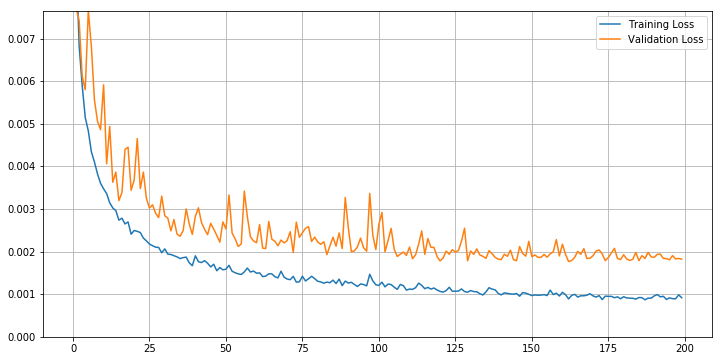

In [50]:
plt.figure(figsize=(12,6))
plt.plot(history_CNN.epoch, history_CNN.history["loss"], label="Training Loss")
plt.plot(history_CNN.epoch, history_CNN.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()
plt.ylim(0, np.percentile(history_CNN.history["val_loss"], 99))
plt.show()

The train images are 97.980% similar


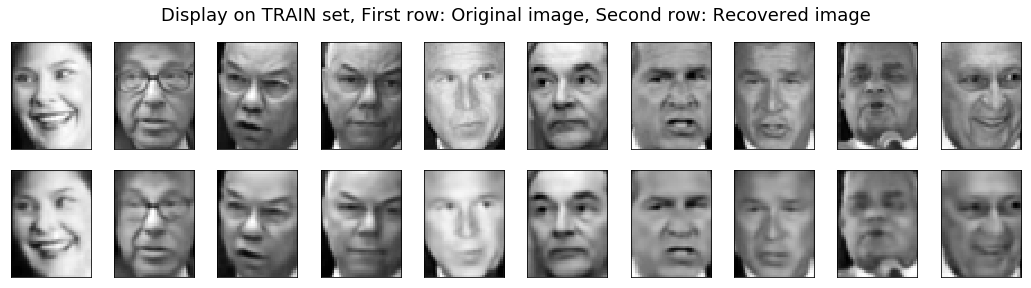

In [56]:
# Retransformation from normalisation
X_predict_train = model.predict(X_stand_train_2D) * 255

fae_sim_train = image_similarity(X_predict_train, X_stand_train_2D * 255)
print("The train images are {:.3f}% similar".format(fae_sim_train*100))

plot_faces_compare(X_train_2D, X_predict_train, h2, w2, 0.8, 10, 
                   suptitle="Display on TRAIN set, First row: Original image, Second row: Recovered image")

The test images are 96.927% similar


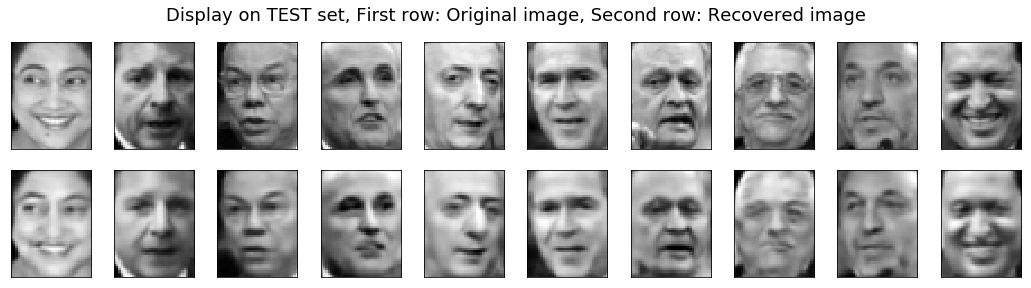

In [55]:
# Retransformation from normalisation
X_predict_test = model.predict(X_stand_test_2D) * 255

fae_sim_test = image_similarity(X_predict_test, X_stand_test_2D * 255)
print("The test images are {:.3f}% similar".format(fae_sim_test*100))

plot_faces_compare(X_stand_test_2D, X_predict_test, h2, w2, 0.8, 10, 
                   suptitle="Display on TEST set, First row: Original image, Second row: Recovered image")

The hyperparameters and architecture for the CNN auto-encoder doen seem to be ideal yet. There are a lot of square-ish artifacts in the images which points towards using different configurations of strides and kernels. Further refinement and retraining is required.